In [ ]:
# Install required packages
#!pip install librosa
#!pip install pydub
#!apt-get install ffmpeg  # FFmpeg is required to handle mp3 files in pydub
#!pip install yt-dlp
# Install required libraries with modern versions
# !pip install torchaudio
!pip install torchlibrosa

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
import json
import os
from IPython.display import Audio
import random
import soundfile as sf
from pathlib import Path
import subprocess
from tqdm import tqdm
import shutil
from torch.utils.data import Dataset, Subset, DataLoader
import gc
import h5py
import torchaudio
import wave
import multiprocessing
import torchlibrosa
from torch.optim.lr_scheduler import LambdaLR

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path_drive = Path("/content/drive/MyDrive/CSE493G1/Final Project/Datasets")
data_path_disk = "/content/Data"
os.makedirs(f"{data_path_disk}/Train", exist_ok=True)
os.makedirs(f"{data_path_disk}/Val", exist_ok=True)
os.makedirs(f"{data_path_disk}/Test", exist_ok=True)

In [ ]:
# Mapping of folder to label
genre_map = {
    "Bluegrass": 0,
    "Country": 1,
    "Folk": 2
}

samples = []
for genre, label in genre_map.items():
    genre_train_dir = os.path.join(data_path_drive, genre, "TestWav")
    for idx, filename in enumerate(os.listdir(genre_train_dir)):
        # if idx > 50:
        #     break
        if not filename.endswith(".wav"):
            continue
        wav_filepath = os.path.join(genre_train_dir, filename)
        print(f"processing {wav_filepath}")
        # duration = open_wav_with_timeout(wav_filepath, timeout = 0.5, max_retries=3)
        try:
            waveform_tensor, sr = torchaudio.load(wav_filepath, backend="soundfile")
            waveform_tensor = waveform_tensor.squeeze(0)
            if waveform_tensor.shape[0] != 640000:
                print(f"{filename} is not 20 seconds, excluding it from training data!\n\n\n")
            else:
                torch.save((waveform_tensor, label), f"{data_path_disk}/Test/{filename}.pt")
        except Exception as e:
            print("Load failed with error:", e)

processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/TestWav/Graceland_splice0.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/TestWav/Graceland_splice1.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/TestWav/Graceland_splice2.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/TestWav/Graceland_splice3.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/TestWav/Graceland_splice4.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/TestWav/Graceland_splice5.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/TestWav/Graceland_splice6.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/TestWav/Graceland_splice7.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/TestWav/Graceland_splice8.wav
processing /content/drive/MyDrive/CSE493G1/Fin

In [ ]:
samples = []
for genre, label in genre_map.items():
    genre_train_dir = os.path.join(data_path_drive, genre, "ValWav")
    for idx, filename in enumerate(os.listdir(genre_train_dir)):
        # if idx > 50 :
        #     break
        if not filename.endswith(".wav"):
            continue
        wav_filepath = os.path.join(genre_train_dir, filename)
        print(f"processing {wav_filepath}")
        try:
            waveform_tensor, sr = torchaudio.load(wav_filepath)
            waveform_tensor = waveform_tensor.squeeze(0)
            if waveform_tensor.shape[0] != 640000:
                print(f"{filename} is not 20 seconds, excluding it from validation data!\n\n\n")
            else:
                torch.save((waveform_tensor, label), f"{data_path_disk}/Val/{filename}.pt")
        except Exception as e:
            print("Load failed with error:", e)

processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/ValWav/Billy Strings - Taking Water (Official Audio)_splice0.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/ValWav/Billy Strings - Taking Water (Official Audio)_splice1.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/ValWav/Billy Strings - Taking Water (Official Audio)_splice2.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/ValWav/Billy Strings - Taking Water (Official Audio)_splice3.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/ValWav/Billy Strings - Taking Water (Official Audio)_splice4.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/ValWav/Billy Strings - Taking Water (Official Audio)_splice5.wav
processing /content/drive/MyDrive/CSE493G1/Final Project/Datasets/Bluegrass/ValWav/Billy Strings - Taking Water (Official Audio)_splice6.wav
processing /c

In [ ]:
class WesternDataset(Dataset):
    def __init__(self, directory):
        self.files = sorted([
            os.path.join(directory, f)
            for f in os.listdir(directory)
            if f.endswith('.pt')
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        tensor, label = torch.load(self.files[idx])
        return tensor, label

In [ ]:
# dst_folder = '/content/Data'
# # Copy all files from Drive to Colab's local storage
# os.makedirs(dst_folder, exist_ok=True)
# # Copy files from the source folder to the destination folder
# for file_name in os.listdir(dataset_path):
#     if file_name == "Bluegrass" or file_name == "Folk" or file_name == "Country":
#         continue
#     src_path = os.path.join(dataset_path, file_name)
#     dst_path = os.path.join(dst_folder, file_name)
#     if os.path.isfile(src_path):
#         shutil.copy(src_path, dst_path)

# # Check the files that were loaded into the local storage
# print("Files loaded into disk:", os.listdir(dst_folder))

In [ ]:
!git clone https://github.com/qiuqiangkong/audioset_tagging_cnn.git
sys.path.append('/content/audioset_tagging_cnn/pytorch')
!wget -O Cnn14_mAP=0.431.pth "https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth?download=1"

Cloning into 'audioset_tagging_cnn'...
remote: Enumerating objects: 714, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 714 (delta 131), reused 120 (delta 120), pack-reused 560 (from 2)
Receiving objects: 100% (714/714), 3.99 MiB | 3.59 MiB/s, done.
Resolving deltas: 100% (412/412), done.
--2025-06-08 21:10:22--  https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3987831/files/Cnn14_mAP=0.431.pth [following]
--2025-06-08 21:10:23--  https://zenodo.org/records/3987831/files/Cnn14_mAP=0.431.pth
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 327428481 (312M) [application/octet-stream]
Saving to: ‘Cnn14_mAP=0.

In [ ]:
from models import Cnn14, init_layer, init_bn, ConvBlock, do_mixup
import torch.nn as nn
import torch.nn.functional as F
from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation

In [ ]:
class Cnn14FreezeAllButLast2(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin,
        fmax, classes_num, final_dropout, reg_on=True):

        super(Cnn14FreezeAllButLast2, self).__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None

        self.final_dropout = final_dropout
        self.reg_on = reg_on

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size,
            win_length=window_size, window=window, center=center, pad_mode=pad_mode,
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=window_size,
            n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db,
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=12,
            freq_drop_width=8, freq_stripes_num=12)

        self.bn0 = nn.BatchNorm2d(64)

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)
        self.conv_block5 = ConvBlock(in_channels=512, out_channels=1024)
        self.conv_block6 = ConvBlock(in_channels=1024, out_channels=2048)

        self.fc1 = nn.Linear(2048, 2048, bias=True)
        self.fc_audioset = nn.Linear(2048, classes_num, bias=True)

        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
        init_layer(self.fc_audioset)

    def forward(self, input, mixup_lambda=None):
        """
        Input: (batch_size, data_length)"""

        x = self.spectrogram_extractor(input)   # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)    # (batch_size, 1, time_steps, mel_bins)
        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        if self.training and self.reg_on:
            x = self.spec_augmenter(x)
        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        # x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        # x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        # x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        # x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block5(x, pool_size=(2, 2), pool_type='avg')
        # x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv_block6(x, pool_size=(1, 1), pool_type='avg')
        if self.reg_on:
            x = F.dropout(x, p=0.3, training=self.training)
        x = torch.mean(x, dim=3)
        (x1, _) = torch.max(x, dim=2)
        x2 = torch.mean(x, dim=2)
        x = x1 + x2
        if self.reg_on:
            x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu_(self.fc1(x))
        if self.reg_on:
            x = F.dropout(x, p=self.final_dropout, training=self.training)
        logits = self.fc_audioset(x)
        return logits


    def forward_features(self, input, mixup_lambda=None):
        """
        Input: (batch_size, data_length)"""

        x = self.spectrogram_extractor(input)   # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)    # (batch_size, 1, time_steps, mel_bins)
        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        if self.training and self.reg_on:
            x = self.spec_augmenter(x)
        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        # x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        # x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        # x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        # x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block5(x, pool_size=(2, 2), pool_type='avg')
        # x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv_block6(x, pool_size=(1, 1), pool_type='avg')
        if self.reg_on:
            x = F.dropout(x, p=0.3, training=self.training)
        x = torch.mean(x, dim=3)
        (x1, _) = torch.max(x, dim=2)
        x2 = torch.mean(x, dim=2)
        x = x1 + x2
        if self.reg_on:
            x = F.dropout(x, p=0.5, training=self.training)
        features = F.relu_(self.fc1(x))
        return features

In [ ]:
class Cnn14(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin,
        fmax, classes_num, final_dropout, reg_on=True):

        super(Cnn14, self).__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None

        self.final_dropout = final_dropout
        self.reg_on = reg_on

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size,
            win_length=window_size, window=window, center=center, pad_mode=pad_mode,
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=window_size,
            n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db,
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=6,
            freq_drop_width=8, freq_stripes_num=6)

        self.bn0 = nn.BatchNorm2d(64)

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)
        self.conv_block5 = ConvBlock(in_channels=512, out_channels=1024)
        self.conv_block6 = ConvBlock(in_channels=1024, out_channels=2048)

        self.fc1 = nn.Linear(2048, 2048, bias=True)
        self.fc_audioset = nn.Linear(2048, classes_num, bias=True)

        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
        init_layer(self.fc_audioset)

    def forward(self, input, mixup_lambda=None):
        """
        Input: (batch_size, data_length)"""

        x = self.spectrogram_extractor(input)   # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)    # (batch_size, 1, time_steps, mel_bins)
        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        if self.training and self.reg_on:
            x = self.spec_augmenter(x)
        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv_block5(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.3, training=self.training)

        x = self.conv_block6(x, pool_size=(1, 1), pool_type='avg')
        if self.reg_on:
            x = F.dropout(x, p=0.3, training=self.training)
        x = torch.mean(x, dim=3)
        (x1, _) = torch.max(x, dim=2)
        x2 = torch.mean(x, dim=2)
        x = x1 + x2
        if self.reg_on:
            x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu_(self.fc1(x))
        if self.reg_on:
            x = F.dropout(x, p=self.final_dropout, training=self.training)
        logits = self.fc_audioset(x)
        return logits

In [ ]:
def train_model(model, criterion, optimizer, scheduler, device, train_loader, val_loader, num_epochs):
    print_factor = 5
    num_classes = 3
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        print(f"epoch {epoch}")
        model.train()
        running_loss = 0.0
        num_examples = 0.0
        num_correct_training = 0.0
        for idx, batch in enumerate(train_loader):
            waveforms, labels = batch
            waveforms, labels = waveforms.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(waveforms)
            if epoch % print_factor == 0:
                _, preds = torch.max(outputs, 1)
                num_correct_training += (preds == labels).sum().item()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            running_loss += loss.item() * waveforms.size(0)
            num_examples += waveforms.size(0)

        avg_loss = running_loss / num_examples
        print(f"train loss = {avg_loss}")
        print(f"Epoch {epoch}: LR = {optimizer.param_groups[0]['lr']:.2e}")
        train_losses.append(avg_loss)
        if epoch % print_factor == 0:
            print(f"Training accuracy : {num_correct_training * 100 / num_examples}%")
            torch.save({
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict()
                        },  f'/content/drive/MyDrive/CSE493G1/Final Project/Models/checkpoint{epoch}.pt')

        # Validate
        model.eval()
        correct = total = 0

        with torch.no_grad():
            running_val_loss = 0.0
            num_val_examples = 0.0
            for waveforms, labels in val_loader:
                waveforms, labels = waveforms.to(device), labels.to(device)
                outputs = model(waveforms)
                val_loss = criterion(outputs, labels)
                if epoch % print_factor == 0:
                    _, preds = torch.max(outputs, 1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
                num_val_examples += waveforms.size(0)
                running_val_loss += val_loss.item() * waveforms.size(0)
            avg_val_loss = running_val_loss / num_val_examples
            print(f"val loss = {avg_val_loss}")
            val_losses.append(avg_val_loss)
            if epoch % print_factor == 0:
                acc = 100 * correct / total
                print(f"Validation Accuracy: {acc:.2f}%")

    return train_losses, val_losses

In [ ]:
def initialize_model(final_dropout, reg_on=True):
    model = Cnn14FreezeAllButLast2(
        sample_rate=32000,
        window_size=1024,
        hop_size=320,
        mel_bins=64,
        fmin=50,
        fmax=14000,
        classes_num=3,
        final_dropout=final_dropout,
        reg_on=reg_on
    ).to(device)

    # Load pretrained weights
    checkpoint = torch.load('/content/Cnn14_mAP=0.431.pth',
                            map_location='cpu')
    state_dict = checkpoint['model']

    # Remove incompatible final layer weights
    state_dict = {k: v for k, v in state_dict.items()
                  if not k.startswith('fc_audioset.')}
    model.load_state_dict(state_dict, strict=False)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze only the final classifier layer
    for param in model.fc_audioset.parameters():
        param.requires_grad = True
    for param in model.fc1.parameters():
        param.requires_grad = True
    for param in model.conv_block6.parameters():
        param.requires_grad = True

    # # Unfreeze all batch norm parameters
    # for name, module in model.named_modules():
    #     if isinstance(module, nn.BatchNorm2d):
    #         for param in module.parameters():
    #             param.requires_grad = True

    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            module.eval()

    return model

In [ ]:
model = initialize_model(final_dropout=0.4, reg_on=True)

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 79679939


In [ ]:
batch_size = 128

In [ ]:
train_data = WesternDataset(f"{data_path_disk}/Train")
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
val_data = WesternDataset(f"{data_path_disk}/Val")
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

In [ ]:
print(len(train_loader.dataset))

6715


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5)
train_model(model, criterion, optimizer, device, train_loader, val_loader, num_epochs=16)

KeyboardInterrupt: 

## **Hyperparameter Tuning**

In [ ]:
lr_exponents = [-5, -4, -3]
reg_exponent_bounds = [-5, -1]
final_dropout_bounds = [0.2, 0.5]
batch_sizes = [8, 16, 32, 64, 128]

In [ ]:
# Find candidate learning rates that make loss drop significantly
reg = 1e-5
train_losses = []
lrs = []
for i in range(15):
    print(i)
    lr_exp = np.random.choice(lr_exponents)
    mantissa = np.random.uniform(1, 10)
    lr = mantissa * 10.0 ** lr_exp
    lrs.append(lr)
    print(f"learning rate = {lr:.2e}")
    model = initialize_model(final_dropout=0, reg_on=False)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss = train_model(model, criterion, optimizer, device,
                             train_loader, val_loader, num_epochs=8)
    train_losses.append(train_loss)

0
learning rate = 4.06e-04
1
learning rate = 4.64e-04
2
learning rate = 9.32e-03
3
learning rate = 3.51e-05
4
learning rate = 7.09e-05
5
learning rate = 3.26e-03
6
learning rate = 3.66e-05
7
learning rate = 8.62e-03
8
learning rate = 8.31e-05
9
learning rate = 9.78e-05
10
learning rate = 7.55e-05
11
learning rate = 1.55e-04
12
learning rate = 1.42e-03
13
learning rate = 2.28e-03
14
learning rate = 2.86e-04


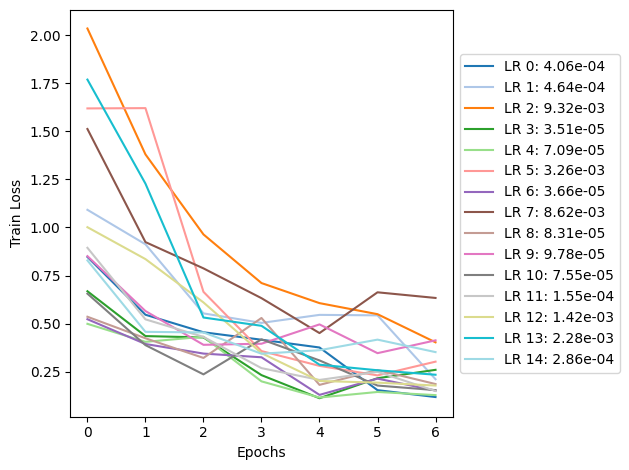

In [ ]:
colors = plt.cm.tab20(np.linspace(0, 1, len(train_losses)))

for i, train_loss in enumerate(train_losses):
    plt.plot(train_loss[1:], color=colors[i])

plt.xlabel("Epochs")
plt.ylabel("Train Loss")

labels = [f"LR {i}: {lr:.2e}" for i, lr in enumerate(lrs)]
plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
def lr_lambda(current_step):
    warmup_steps = 500
    steps_per_epoch = len(train_loader)
    epoch = current_step // steps_per_epoch

    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))

    # Halve the LR every 15 epochs after warmup
    decay_factor = 0.5 ** (epoch // 15)
    return decay_factor

In [ ]:
# Try candidate learning rates on full dataset
# Use learning rate warmup
train_losses = []
val_losses = []
lr_candidates = [9.32e-03, 4.06e-04, 1.42e-03]
reg_candidates = [1e-5, 5e-5, 1e-4]
lrs = []
regs = []
i = 0
for lr in lr_candidates:
    for reg in reg_candidates:
        print(i)
        # perterb the lr and reg
        lr += np.random.uniform(-0.1 * lr, 0.1 * lr)
        reg += np.random.uniform(-0.1 * reg, 0.1 * reg)
        print(f"learning rate = {lr:.2e}, reg = {reg:.2e}")
        model = initialize_model(final_dropout=0, reg_on=False)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
        scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
        train_loss, val_loss = train_model(model, criterion, optimizer, scheduler, device,
                                train_loader, val_loader, num_epochs=3)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        i += 1

0
learning rate = 9.64e-03, reg = 9.56e-06
epoch loss = 1.5208405612035198
epoch loss = 0.6039593123715047
epoch loss = 0.5284811649230196
1
learning rate = 8.89e-03, reg = 4.65e-05
epoch loss = 1.269452405073531
epoch loss = 0.6406652649036558
epoch loss = 0.6018717283156942
2
learning rate = 8.71e-03, reg = 9.30e-05
epoch loss = 1.2286652693531892
epoch loss = 0.6933810785912082
epoch loss = 0.609195738307416
3
learning rate = 3.92e-04, reg = 9.95e-06
epoch loss = 1.2422931429173463
epoch loss = 0.5952596781197006
epoch loss = 0.42073819729612555
4
learning rate = 3.71e-04, reg = 4.76e-05
epoch loss = 1.2213405093947898
epoch loss = 0.5959729312119516
epoch loss = 0.4150552017157946
5
learning rate = 3.80e-04, reg = 1.06e-04
epoch loss = 1.2884032234804716
epoch loss = 0.5773866702794851
epoch loss = 0.45553525833611336
6
learning rate = 1.55e-03, reg = 9.12e-06
epoch loss = 1.2544400684219283
epoch loss = 0.5527764921923316
epoch loss = 0.47574969181265303
7
learning rate = 1.56e-03

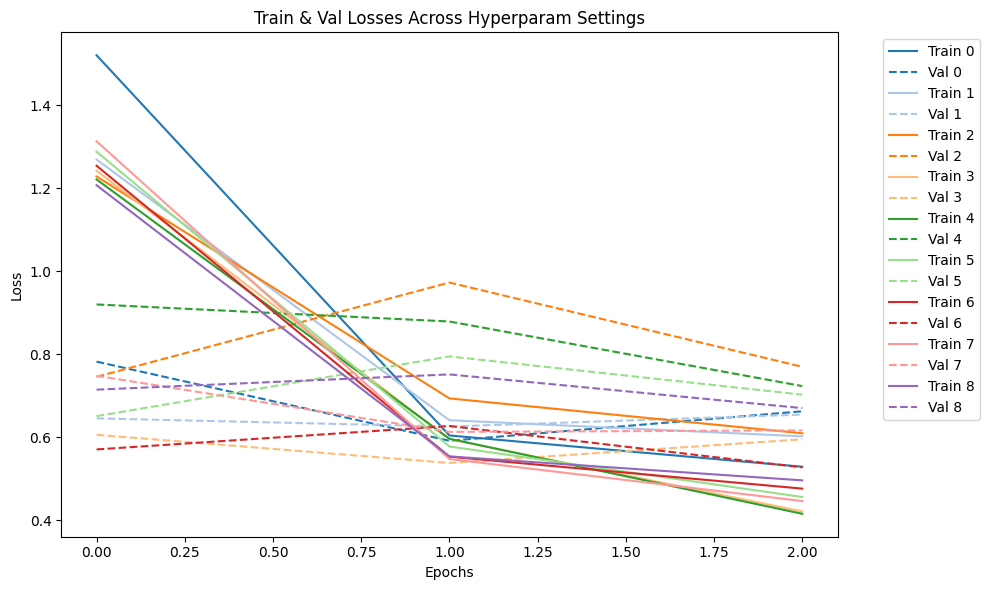

In [ ]:
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20.colors  # Up to 20 unique colors

for idx, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
    label = idx
    color = colors[idx % len(colors)]
    plt.plot(train_loss, label=f"Train {label}", color=color, linestyle='-')
    plt.plot(val_loss, label=f"Val {label}", color=color, linestyle='--')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train & Val Losses Across Hyperparam Settings")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
lr = 3.71e-04
reg = 8.76e-05
model = initialize_model(final_dropout=0.4, reg_on=True)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
train_loss, val_loss = train_model(model, criterion, optimizer, scheduler, device,
                                   train_loader, val_loader, num_epochs=50)

Number of trainable parameters: 60833795
epoch 0
train loss = 1.1164628566420975
Epoch 0: LR = 3.93e-05
Training accuracy : 40.71481757259866%
val loss = 1.0143688570586662
Validation Accuracy: 56.39%
epoch 1
train loss = 0.9361552991089498
Epoch 1: LR = 7.87e-05
val loss = 0.7767565865863236
epoch 2
train loss = 0.6399604899707518
Epoch 2: LR = 1.18e-04
val loss = 0.7145544861193588
epoch 3
train loss = 0.502755827963219
Epoch 3: LR = 1.57e-04
val loss = 0.5983399212509767
epoch 4
train loss = 0.4266131219807083
Epoch 4: LR = 1.97e-04
val loss = 0.5042900334025983
epoch 5
train loss = 0.3619641288216222
Epoch 5: LR = 2.36e-04
Training accuracy : 85.74832464631422%
val loss = 0.47306278445069355
Validation Accuracy: 79.95%
epoch 6
train loss = 0.3120465276140112
Epoch 6: LR = 2.75e-04
val loss = 0.4352935667623553
epoch 7
train loss = 0.2758733891854957
Epoch 7: LR = 3.15e-04
val loss = 0.37364002397484647
epoch 8
train loss = 0.23886978652436433
Epoch 8: LR = 3.54e-04
val loss = 0.493

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
},  '/content/drive/MyDrive/CSE493G1/Final Project/Models/checkpoint50.pt')


In [ ]:
lr = 3.71e-04 * 0.5
reg = 4.76e-05
criterion = torch.nn.CrossEntropyLoss()
scheduler = None
train_loss2, val_loss2 = train_model(model, criterion, optimizer, scheduler, device,
                                   train_loader, val_loader, num_epochs=10)

epoch 0
train loss = 0.3435070061941069
Training accuracy : 86.96947133283693%
val loss = 0.45526450338369623
Validation Accuracy: 80.33%
epoch 1
train loss = 0.3254559150890725
val loss = 0.5895999509719828
epoch 2
train loss = 0.308071853819616
Training accuracy : 88.72673119880864%
val loss = 0.33585855377870694
Validation Accuracy: 85.46%
epoch 3
train loss = 0.2871889341481124
val loss = 0.4407950787989418
epoch 4
train loss = 0.29188002349721437
Training accuracy : 89.03946388682056%
val loss = 0.543436596865642
Validation Accuracy: 74.44%
epoch 5
train loss = 0.2677604746836295
val loss = 0.4681327045430665
epoch 6
train loss = 0.25267312015869325
Training accuracy : 90.09679821295607%
val loss = 0.4667684920225526
Validation Accuracy: 80.45%
epoch 7
train loss = 0.25591382599551554
val loss = 0.4443049788811153
epoch 8
train loss = 0.24466546429286495
Training accuracy : 91.02010424422934%
val loss = 0.49076945352412404
Validation Accuracy: 77.19%
epoch 9
train loss = 0.2346072

In [ ]:

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
},  '/content/drive/MyDrive/CSE493G1/Final Project/Models/checkpoint2.pt')

In [ ]:
lr = 3.71e-04 * 0.5 * 0.5
reg = 4.76e-05
criterion = torch.nn.CrossEntropyLoss()
scheduler = None
train_loss3, val_loss3 = train_model(model, criterion, optimizer, scheduler, device,
                                   train_loader, val_loader, num_epochs=10)

epoch 0
train loss = 0.24638918021767334
Training accuracy : 90.7222635889799%
val loss = 0.536726144359524
Validation Accuracy: 80.70%
epoch 1
train loss = 0.2471123908494536
val loss = 0.5404800148610782
epoch 2
train loss = 0.2136262354394525
Training accuracy : 91.98808637379003%
val loss = 0.5629637258542809
Validation Accuracy: 78.45%
epoch 3
train loss = 0.21967019916290856
val loss = 0.5282957472075197
epoch 4
train loss = 0.21474724208696155
Training accuracy : 91.64556962025317%
val loss = 0.44457654643775824
Validation Accuracy: 81.33%
epoch 5
train loss = 0.2282786351082845
val loss = 0.6818193313583993
epoch 6
train loss = 0.2046511772246123
Training accuracy : 92.46463142218913%
val loss = 0.6421706853317737
Validation Accuracy: 78.20%
epoch 7
train loss = 0.19338143235564853
val loss = 0.6612610995050585
epoch 8
train loss = 0.20811769538354447
Training accuracy : 92.16679076693968%
val loss = 0.4484078586008166
Validation Accuracy: 82.96%
epoch 9
train loss = 0.18346511

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
},  '/content/drive/MyDrive/CSE493G1/Final Project/Models/checkpoint3.pt')

In [ ]:
lr = 3.71e-04 * 0.5 * 0.5 * 0.5
reg = 4.76e-05
criterion = torch.nn.CrossEntropyLoss()
scheduler = None
train_loss4, val_loss4 = train_model(model, criterion, optimizer, scheduler, device,
                                   train_loader, val_loader, num_epochs=10)

epoch 0
train loss = 0.2974511057992791
Training accuracy : 88.38421444527178%
val loss = 0.6467288390436866
Validation Accuracy: 78.57%
epoch 1
train loss = 0.3012937873979158
val loss = 0.5857284344676742
epoch 2
train loss = 0.28746546373736565
Training accuracy : 88.801191362621%
val loss = 0.6576749408678303
Validation Accuracy: 75.69%
epoch 3
train loss = 0.28904176570547224
val loss = 0.5929570465084902
epoch 4
train loss = 0.29348883871169384
Training accuracy : 89.20327624720774%
val loss = 0.682238983779324
Validation Accuracy: 74.44%
epoch 5
train loss = 0.3082001787819085
val loss = 0.6123564404652531
epoch 6
train loss = 0.282055065397531
Training accuracy : 89.18838421444528%
val loss = 0.551198743899962
Validation Accuracy: 79.70%
epoch 7
train loss = 0.2847006456406367
val loss = 0.6416780961336648
epoch 8
train loss = 0.2847802457797021
Training accuracy : 89.1734921816828%
val loss = 0.5665957537061888
Validation Accuracy: 79.57%
epoch 9
train loss = 0.281132343185098

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
},  '/content/drive/MyDrive/CSE493G1/Final Project/Models/checkpoint4.pt')

In [ ]:
train_losses = [
    1.0204630443788871,
    0.6071255033662403,
    0.4996848254086629,
    0.4477438472538676,
    0.39721921551875544,
    0.372956348832472,
    0.4512374386313418,
    0.6074317094379632,
    0.8059962313563985,
    0.4753175823926393,
    0.3929861998700066,
    0.44402372634686027,
    0.47441705354362484,
    0.3961269121070629,
    0.3365095198775793,
    0.31924939306476446,
    0.3206091963481477,
    0.7074250235765263,
    0.3106180017596292,
    0.336895626681293,
    0.2829462892824558,
    0.32656058492894857,
]

val_losses = [
    0.7058606122370651,
    0.5613112419022056,
    0.5149386743069592,
    0.4122713309780398,
    0.39952587554777474,
    0.4240967531998952,
    0.5907357713898509,
    0.44769574260166417,
    0.3928549839066981,
    0.5580635081817931,
    0.4047432957324468,
    0.384208882885768,
    0.44655809143936276,
    0.34409233699914504,
    0.4030524261930682,
    0.38748710730432867,
    0.38033641236168997,
    0.44309593629054633,
    0.4061018916915981,
    0.3905236213036199,
    0.3847479746025756,
    0.39287197718718897,
]

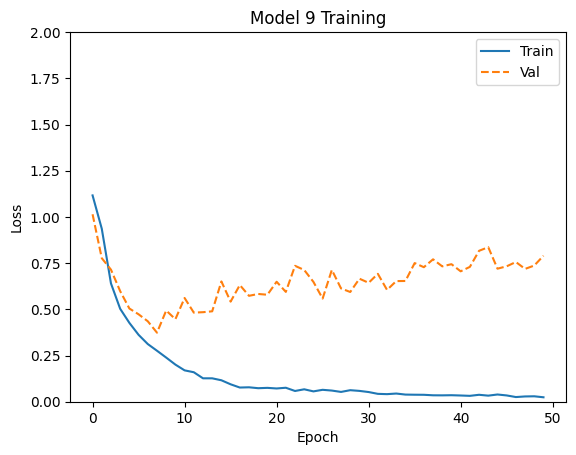

In [ ]:
plt.plot(train_loss, label=f"Train", linestyle='-')
plt.plot(val_loss, label=f"Val", linestyle='--')
plt.xlabel("Epoch")
plt.ylim(0, 2)
plt.ylabel("Loss")
plt.title("Model 9 Training")
plt.legend()

In [ ]:
final_model = Cnn14FreezeAllButLast2(
    sample_rate=32000,
    window_size=1024,
    hop_size=320,
    mel_bins=64,
    fmin=50,
    fmax=14000,
    classes_num=3,
    final_dropout=0,
    reg_on=False
).to(device)

# Load pretrained weights
checkpoint = torch.load('/content/drive/MyDrive/CSE493G1/Final Project/Models/Model 8/checkpoint40.pt',
                        map_location='cpu')
state_dict = checkpoint['model_state_dict']
final_model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [ ]:
batch_size = 32

In [ ]:
test_data = WesternDataset(f"{data_path_disk}/Test")
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

In [ ]:
print(len(test_loader.dataset))

1504


In [ ]:
final_model.eval()
with torch.no_grad():
    num_test_examples = 0.0
    correct = 0.0
    for waveforms, labels in test_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)
        outputs = final_model(waveforms)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        num_test_examples += waveforms.size(0)
    acc = 100 * correct / num_test_examples
    print(f"Test Accuracy: {acc:.2f}%")

Test Accuracy: 80.45%


In [ ]:
from collections import defaultdict
import torch.nn.functional as F

genre_names = {0: "bluegrass", 1: "country", 2: "folk"}

final_model.eval()
song_logits = defaultdict(list)
song_labels = {}

with torch.no_grad():
    for i in range(len(test_data)):
        waveform, label = test_data[i]
        file_path = test_data.files[i]
        song_name = os.path.basename(file_path).split('_splice')[0]

        waveform = waveform.to(device).unsqueeze(0)  # add batch dimension
        output = final_model(waveform)  # logits
        output = output.squeeze(0).cpu()

        song_logits[song_name].append(output)
        song_labels[song_name] = label  # assumes all splices of a song have same label

# Aggregate predictions by summing logits
correct = 0
total = 0

for song, logits_list in song_logits.items():
    summed_logits = torch.stack(logits_list).sum(dim=0)
    pred_class = torch.argmax(summed_logits).item()
    true_class = song_labels[song]

    if pred_class == true_class:
        print(f"{song}: correct")
        correct += 1
    else:
        guessed_genre = genre_names[pred_class]
        print(f"{song}: incorrect (guessed {guessed_genre})")

    total += 1

acc = 100 * correct / total
print(f"\nSong-level Test Accuracy: {acc:.2f}%")


Abigail Washburn & The Sparrow Quartet - ＂Oh Me, Oh My＂ [audio only]: correct
Bad, Bad Leroy Brown: correct
Big Black Car: correct
Black Mountain Rag: correct
Brakeman's Blues: correct
Bridge You're Gonna Burn: correct
Chris Stapleton - Devil Always Made Me Think Twice (Official Audio): correct
Clawhammer Medley: correct
Cocaine Habit (feat. Ryan Engleman) - Shane Smith & The Saints: correct
Crooked Still - ＂Tell Her To Come Back Home＂ [Official Audio]: correct
Doing My Time: correct
Dying Breed: correct
Family Tradition: correct
Fleet Foxes - Mykonos: incorrect (guessed country)
Foreign Fields - Don't Give Up: correct
Freeborn Man: correct
Glen Campbell - Southern Nights (Official Audio): correct
Graceland: correct
Gregory Alan Isakov - San Luis (OFFICIAL VIDEO): correct
Homesick for Virginia: correct
I Am A Man Of Constant Sorrow (With Band): correct
I Give You the Morning: incorrect (guessed bluegrass)
I Know Your Wandering Heart: correct
I'M SO LONESOME I COULD CRY (1949) by Hank W

In [ ]:
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for waveforms, targets in dataloader:
            waveforms = waveforms.to(device)
            targets = targets.to(device)

            # Forward pass to extract features before classifier
            feats = model.forward_features(waveforms)

            embeddings.append(feats.cpu())
            labels.append(targets.cpu())

    return torch.cat(embeddings), torch.cat(labels)

In [ ]:
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_embeddings(embeddings, labels, method='tsne', n_components=2):
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, perplexity=30, random_state=42)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=42)
    else:
        raise ValueError("method must be 'tsne' or 'umap'")

    reduced = reducer.fit_transform(embeddings)

    # Define custom 3-color colormap: Bluegrass = blue, Country = orange, Folk = green
    cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])  # or any colors you like
    genre_labels = ['Bluegrass', 'Country', 'Folk']

    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap=cmap, s=10, alpha=0.7)
    plt.title(f'{method.upper()} projection of CNN14 test embeddings')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')

    # Colorbar with genre labels
    cbar = plt.colorbar(scatter, ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(genre_labels)
    cbar.set_label('Genre')

    plt.grid(True)
    plt.show()

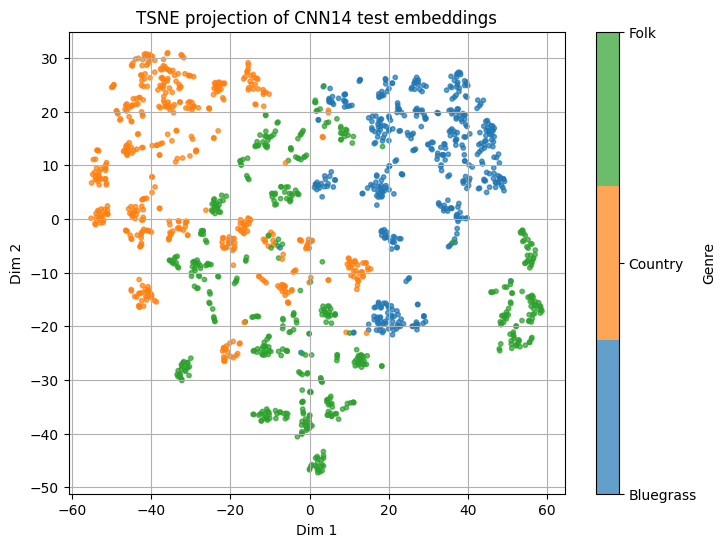

In [ ]:
embeddings, labels = extract_embeddings(final_model, test_loader, device)
plot_embeddings(embeddings.numpy(), labels.numpy(), method='tsne')

In [ ]:
def plot_embeddings(embeddings, labels, method='tsne', n_components=3):
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, perplexity=30, random_state=42)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components, random_state=42)
    else:
        raise ValueError("method must be 'tsne' or 'umap'")

    reduced = reducer.fit_transform(embeddings)

    cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])  # Bluegrass, Country, Folk
    genre_labels = ['Bluegrass', 'Country', 'Folk']

    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2],
                         c=labels, cmap=cmap, s=15, alpha=0.8)

    ax.set_title(f'{method.upper()} projection of CNN14 test embeddings (3D)', fontsize=10)
    # ax.set_xlabel('Dim 1')
    # ax.set_ylabel('Dim 2')

    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    fig.tight_layout(pad=3.0)

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=genre_labels[i],
                              markerfacecolor=cmap(i), markersize=6) for i in range(3)]
    ax.legend(handles=legend_elements, title="Genre", loc='best')

    plt.show()

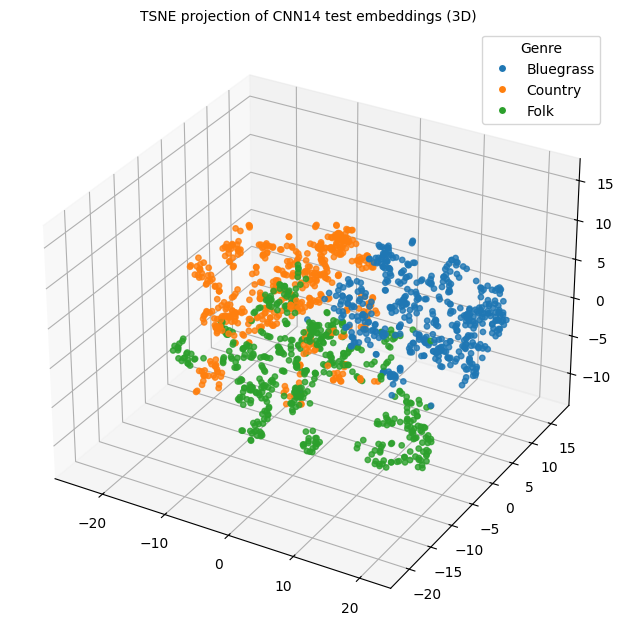

In [ ]:
embeddings, labels = extract_embeddings(final_model, test_loader, device)
plot_embeddings(embeddings.numpy(), labels.numpy(), method='tsne')